# Bias Variance Tradeoff / Validation Curve / Learning Curve



adapted from: 

*   https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb

*   https://scikit-learn.org/stable/modules/learning_curve.html





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

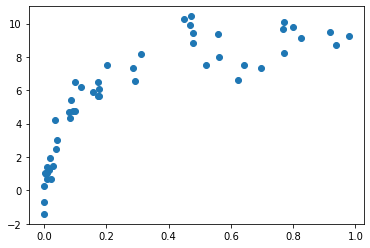

In [ ]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(50)
plt.scatter(X, y);

We can now visualize our data, along with polynomial fits of several degrees:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


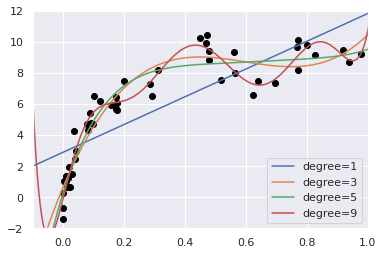

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5, 9]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules 


## Validation Curves for a fix training size


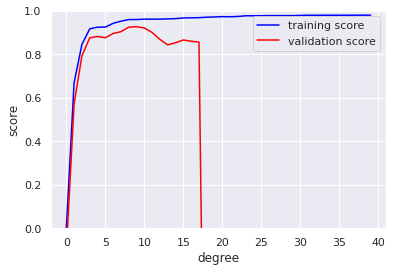

In [ ]:
from sklearn.model_selection import validation_curve

degree = np.arange(0, 40)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7, scoring="r2")

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.



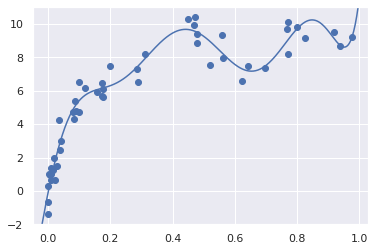

In [ ]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(8).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Validation Curves with two different training size


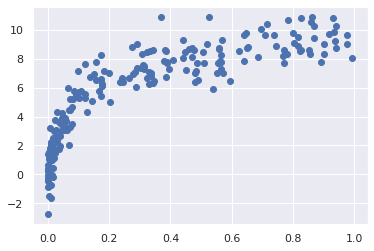

In [ ]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

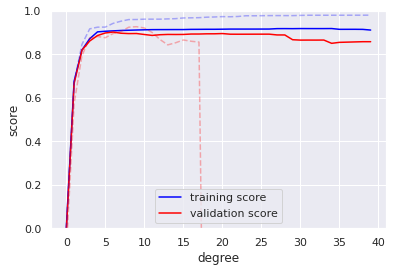

In [ ]:
degree = np.arange(40)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');


The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.


A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

The general behavior we would expect from a learning curve is this:

- A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.


The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

### Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

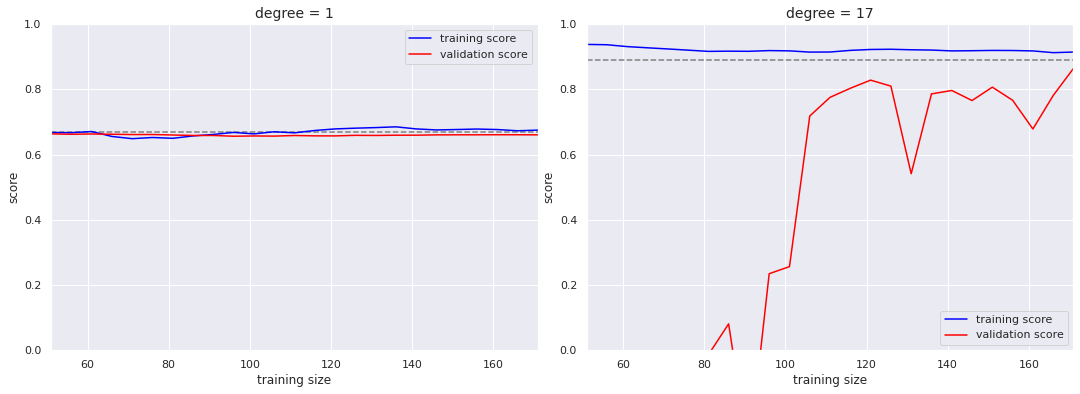

In [ ]:

from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([1, 17]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X2, y2, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

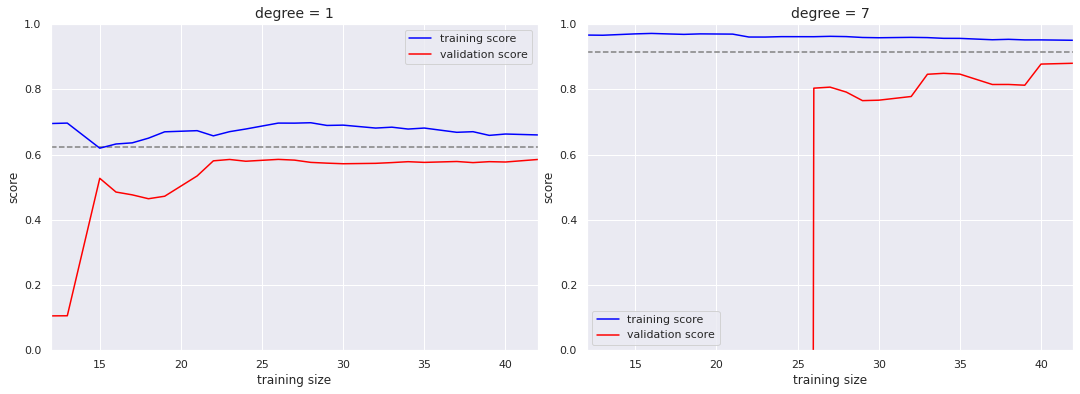

In [ ]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([1, 7]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')